# Exploring Efficacy Scores
Heretofore we have looked at attack statistics of a single attack and the probability of each result from the "fight to the death"

A more versatile metric would be to understand what is the expected outcome of any single-attack tactick. Should we attack downhill or maintain a defensive hill bonus? This would allow us to quickly build hurristics about the number of troops we need to stack for an upcoming invader, or to take one out preemptively

### __Disclaimer__
This is an experimental workbook and is left in its last-used state to show process and thought evolution 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.image as mpimg

In [2]:
rng = np.random.default_rng()

# this rolls one n_dice with n_sides once each. 
def roll_dice(n_sides, n_dice):
    return (rng.integers(low = 1, high = n_sides, size = n_dice, endpoint=True)).tolist()


In [3]:
# Let's first get the confidence of a single attack, 3 attackers vs 2 defenders on flat ground.

def resolve_battle(a_rolls, d_rolls, debug=False):
    nad = len(a_rolls)
    ndd = len(d_rolls)
    min_die = min([nad, ndd])
    a_rolls.sort(reverse=True)
    d_rolls.sort(reverse=True)
    score = {'attack':0, 'defend':0, 'tracker':[]}
    if debug:
        print('a rolls: ', a_rolls)
        print('d rolls: ', d_rolls)
    for i in range(min_die):
        if a_rolls[i] > d_rolls[i]:
            score['defend'] -= 1
            score['tracker'].append(0)
        else:
            score['attack'] -= 1
            score['tracker'].append(1)
    if debug: print(score)
    return score   

In [4]:
score = resolve_battle(roll_dice(6, 3), roll_dice(6, 2), debug=True)

a rolls:  [6, 3, 3]
d rolls:  [6, 2]
{'attack': -1, 'defend': -1, 'tracker': [1, 0]}


In [5]:
def expected_score_detailed(n_a_dice, n_d_dice, n_throws=10000, n_a_sides=6, n_d_sides=6, debug = False):
    score = {'attack':0, 'defend':0}
    round_tracker = []
    for i in range(n_throws):
        this_round = resolve_battle(roll_dice(n_a_sides, n_a_dice), roll_dice(n_d_sides, n_d_dice))
        round_tracker.append([this_round['attack'], this_round['defend']])
        score['attack'] += this_round['attack']
        score['defend'] += this_round['defend']
    if debug: print(score)
    
    # get a histo of results
    rounds = np.array(round_tracker).T
    vals_a = set(rounds[0])
    vals_d = set(rounds[1])
    bins = [-2,-1,0,1]
    histos = [np.histogram(rounds[0], bins=bins,density=True), np.histogram(rounds[1],bins=bins,density=True)]
    if debug: print(histos)
    
    # averages
    m_a = score['attack'] / n_throws
    m_d = score['defend'] / n_throws
    if debug: print('mean_a: {0:.2f}, mean_d: {1:.2f}'.format(m_a, m_d))
    
    # calculate the standard deviation
    error_a, error_d = 0, 0
    for i in range(n_throws):
        error_a += np.power(round_tracker[i][0] - m_a, 2)
        error_d += np.power(round_tracker[i][1] - m_d, 2)
    if debug: print('error_a: {0:.2f}, error_d: {1:.2f}'.format(error_a, error_d))
        
    s_a = np.power(error_a / (n_throws - 1) ,.5)
    s_d = np.power(error_d / (n_throws - 1) ,.5)
    if debug: print('std_a: {0:.2f}, std_d: {1:.2f}'.format(s_a, s_d))
    result = {
        'attack':{
            'mean': m_a,
            'std': s_a
        },
        'defend':{
            'mean': m_d,
            'std': s_d
        }
    }
    return result, histos
 

In [6]:
results, histos = expected_score_detailed(3,2, debug=True)

{'attack': -9006, 'defend': -10994}
[(array([0.2824, 0.3358, 0.3818]), array([-2, -1,  0,  1])), (array([0.3818, 0.3358, 0.2824]), array([-2, -1,  0,  1]))]
mean_a: -0.90, mean_d: -1.10
error_a: 6543.20, error_d: 6543.20
std_a: 0.81, std_d: 0.81


In [7]:
import scipy.stats as stats

def plot_some_shit(results, histos):
    x = np.linspace(-4, 2, 100)
    m_a = results['attack']['mean']
    s_a = results['attack']['std']
    m_d = results['defend']['mean']
    s_d = results['defend']['std']


    fig, ax = plt.subplots(figsize=(8,5))
    width = 0.2
    a_x = histos[0][1]
    attack = ax.bar(histos[0][1][:-1] - width/2, histos[0][0], width, label = "Attack")
    defend = ax.bar(histos[1][1][:-1] + width/2, histos[1][0], width, label = "Defend")
    a_dist = ax.plot(x, stats.norm.pdf(x, m_a, s_a), label="A Dist")
    d_dist = ax.plot(x, stats.norm.pdf(x, m_d, s_d), label="D Dist")
    ax.set_xticks(range(-2,1))
    ax.yaxis.grid()
    ax.legend()
    plt.show()

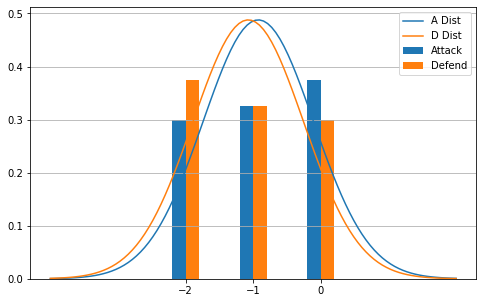

In [8]:
a,b = expected_score_detailed(3,2)
plot_some_shit(a, b)

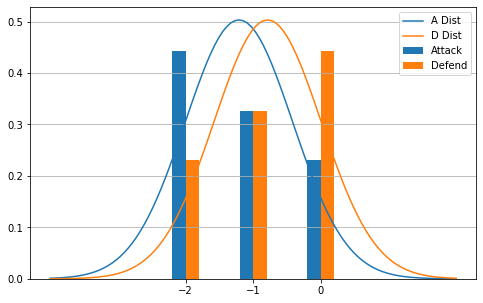

In [9]:
a,b = expected_score_detailed(2,2)
plot_some_shit(a, b)

{'attack': -17036, 'defend': -2964}
[(array([0.7423, 0.219 , 0.0387]), array([-2, -1,  0,  1])), (array([0.0387, 0.219 , 0.7423]), array([-2, -1,  0,  1]))]
mean_a: -1.70, mean_d: -0.30
error_a: 2859.47, error_d: 2859.47
std_a: 0.53, std_d: 0.53


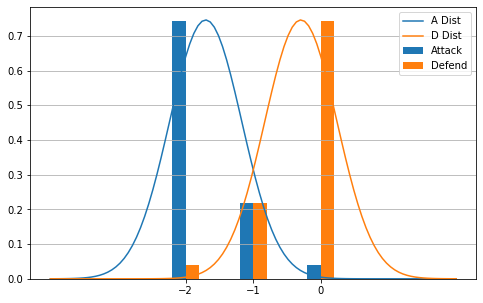

In [10]:
a,b = expected_score_detailed(3,2, n_d_sides=19, debug=True)
plot_some_shit(a, b)

This is great. We can see both distributions have identical standard deviations, and the mean for each is an equal but opposite distance away from -1. This points to one thing: we are making this way more complicated than it needs to be

Knowing now that the attackers lost is an equal but opposite amount to defenders still alive is obvious in hindsight. Let's simplify things now with our problem space reduced

In [11]:
# This is great, but in the end we one one key indicator of how effective our attack will be.
# What we really want is the expected ratio of number attackers lost to the number of defenders lost.
# Another way to think about this is the distance between the curves

def expected_score(n_a_dice, n_d_dice, n_throws=10000, n_a_sides=6, n_d_sides=6, debug = False):
    # we are going to normalize by the number of dice wagered.
    # Attacking 3v1 really only risks 1 dice lost.
    # This will help us compare all cases 3v1, 2v2, and 1v2 together
    dice_fighting_per_round = min([n_a_dice, n_d_dice])
    attackers_lost = 0
    round_tracker = []
    for i in range(n_throws):
        this_round = resolve_battle(roll_dice(n_a_sides, n_a_dice), roll_dice(n_d_sides, n_d_dice))
        round_tracker += this_round['tracker']
        attackers_lost -= this_round['attack']
    if debug:
        print('attackers lost: ', attackers_lost)
        print('attackers wagered: ', (n_throws * dice_fighting_per_round))
    
    # let's get the average first
    loss_per_wagered = attackers_lost / (n_throws * dice_fighting_per_round)
    if debug: print('score {0:.2f}'.format(loss_per_wagered))
        
    # get a histo of results
    bins = [0,1,2]
    histo, edges = np.histogram(round_tracker, bins=bins,density=True)
    if debug: print('histo: ',histo)
        
    # calculate standard deviation
    error = 0
    for i in range(n_throws):
        error += np.power(round_tracker[i] - loss_per_wagered, 2)
    if debug: print('error: {0:.2f}'.format(error))
    std = np.power(error / (n_throws - 1) ,.5)
    if debug: print('std: {0:.2f}'.format(std))
  
    return loss_per_wagered, std, histo, edges

In [12]:
expected_score(3,2, debug=True)

attackers lost:  8987
attackers wagered:  20000
score 0.45
histo:  [0.55065 0.44935]
error: 2473.48
std: 0.50


(0.44935, 0.49736627330466754, array([0.55065, 0.44935]), array([0, 1, 2]))

In [13]:
def plot_some_shit_2(mean, std, histo, edges):
    x = np.linspace(-1, 2, 100)

    fig, ax = plt.subplots(figsize=(8,5))
    width = 0.2
    
    ax.set_title("Attackers Lost Per Wagered")
    attack = ax.bar(edges[:-1], histo, width)
    a_dist = ax.plot(x, stats.norm.pdf(x, mean, std), label="A Dist")
    a_point = ax.errorbar(mean, 1, xerr=std, fmt='-o', capsize=6,label="std")
    ax.set_xticks(range(2))
    ax.yaxis.grid()
    ax.legend()
    plt.show()

attackers lost:  4205
attackers wagered:  10000
score 0.42
histo:  [0.5795 0.4205]
error: 2436.80
std: 0.49


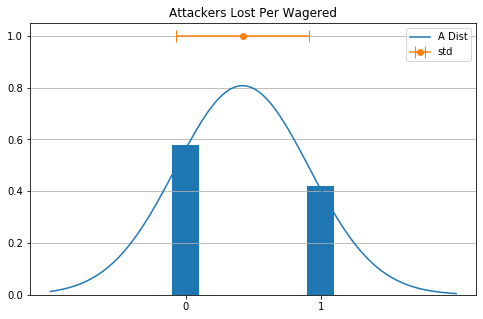

In [14]:
m, s, h, e = expected_score(2, 1, debug=True)
plot_some_shit_2(m, s, h, e)

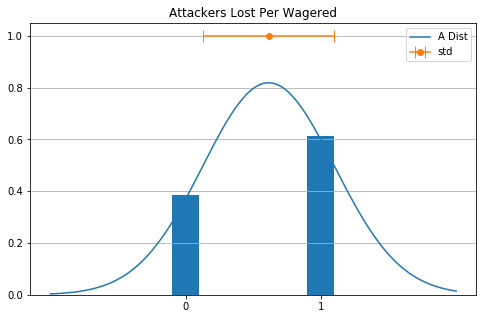

In [15]:
m, s, h, e = expected_score(2, 2)
plot_some_shit_2(m, s, h, e)

attackers lost:  17062
attackers wagered:  20000
score 0.85
histo:  [0.1469 0.8531]
error: 1268.03
std: 0.36


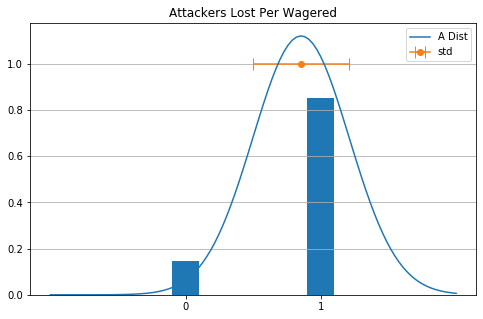

In [16]:
m, s, h, e = expected_score(3, 2, n_d_sides=19, debug=True)
plot_some_shit_2(m, s, h, e)

At this point we've outgrowing our normal distribution assumption. Moreover we are starting to recognize signs of a Bernouli distribution. Discrete outcomes of 1 or 0 with p(0) = 1-p(1)

Now that we look closely, we see that our "score" metric is exactly the same as the probability of an outcome of 1, which is precisely what Bernouli distribution states

Now we have a better and more acurate way of assessing expected value and variance: E(X)=p, Var(X) = p(1-p), and Std(X) = sqrt(p(1-p))

In [17]:
def expected_score_new(n_a_dice, n_d_dice, n_throws=10000, n_a_sides=6, n_d_sides=6, debug = False):
    dice_fighting_per_round = min([n_a_dice, n_d_dice])
    attackers_lost = 0
    round_tracker = []
    for i in range(n_throws):
        this_round = resolve_battle(roll_dice(n_a_sides, n_a_dice), roll_dice(n_d_sides, n_d_dice))
        round_tracker += this_round['tracker']
        attackers_lost -= this_round['attack']
    if debug:
        print('attackers lost: ', attackers_lost)
        print('attackers wagered: ', (n_throws * dice_fighting_per_round))
        
    # get a histo of results
    bins = [0,1,2]
    histo, edges = np.histogram(round_tracker, bins=bins,density=True)
    if debug: print('histo: ',histo)
    
    expectation = histo[1]
    std = np.power(expectation * (1- expectation),.5)
    if debug:
        print('expectation: {0:.2f}'.format(expectation))
        print('std: {0:.2f}'.format(std))
  
    return expectation, std, histo, edges

In [18]:
m, s, h, e = expected_score_new(2, 1, debug=True)

attackers lost:  4179
attackers wagered:  10000
histo:  [0.5821 0.4179]
expectation: 0.42
std: 0.49


In [19]:
import math
def c_of_n_x(n,x):
    numerator = math.factorial(n)
    denominator = math.factorial(x) * math.factorial(n-x)
    return numerator/denominator
    
def sample_binomial(p, n):
    distribution = [ c_of_n_x(n,z) * np.power(p, z) * np.power(1-p, n-z) for z in range(n+1)]
    return distribution

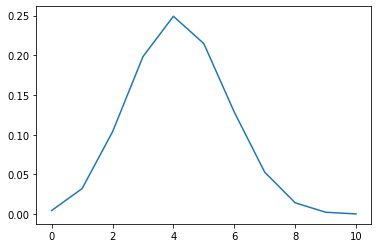

In [20]:
n_samples = 10
plt.plot(range(0,n_samples+1),sample_binomial(m, n_samples))
plt.show()

In [21]:
# Let's get fancy with our plots

import matplotlib.gridspec as grid_spec

In [22]:
# make some data

    

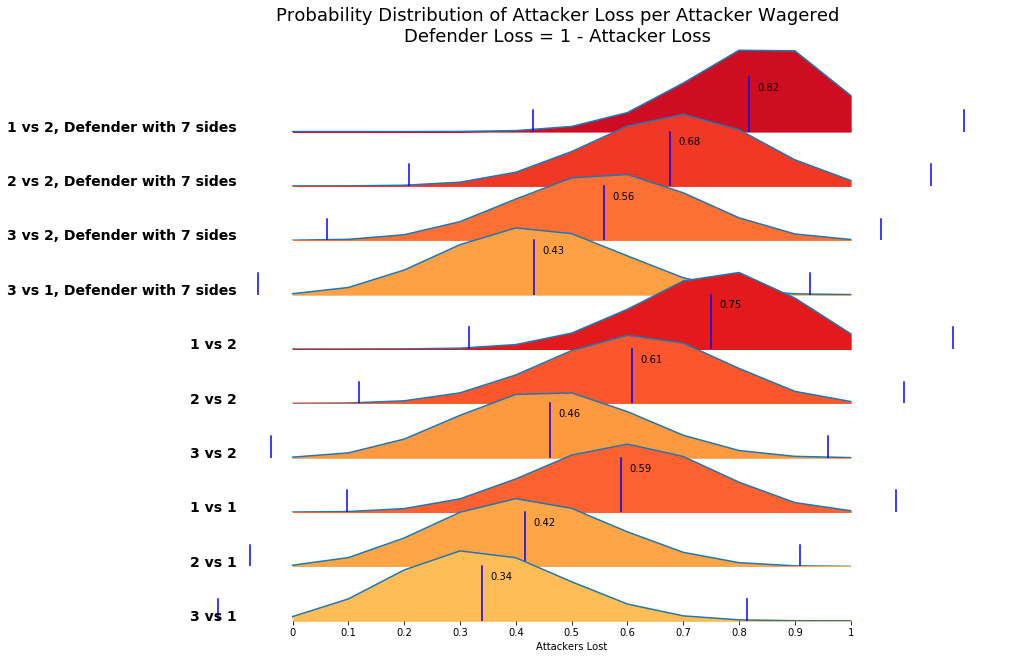

In [23]:
n_throws = 10000
n_bins = 10
scenarios = [
    (3,1, n_throws, 6, 6),
    (2,1, n_throws, 6, 6),
    (1,1, n_throws, 6, 6),
    (3,2, n_throws, 6, 6),
    (2,2, n_throws, 6, 6),
    (1,2, n_throws, 6, 6),
    (3,1, n_throws, 6, 7),
    (3,2, n_throws, 6, 7),
    (2,2, n_throws, 6, 7),
    (1,2, n_throws, 6, 7)
]
names = [
    '3 vs 1',
    '2 vs 1',
    '1 vs 1',
    '3 vs 2',
    '2 vs 2',
    '1 vs 2',
    '3 vs 1, Defender with 7 sides',
    '3 vs 2, Defender with 7 sides',
    '2 vs 2, Defender with 7 sides',
    '1 vs 2, Defender with 7 sides',
]
scenarios.reverse()
names.reverse()
x = range(n_bins+1)
y = []
c = []
cm = plt.cm.get_cmap('YlOrRd')
stats = []
for args in scenarios:
    m, s, h, e = expected_score_new(*args)
    stats.append( [m, s] )
    y += [ sample_binomial(m, n_bins) ]
    c += [cm(m)]

gs = (grid_spec.GridSpec(len(scenarios),1))

fig = plt.figure(figsize=(16,11))
fig.suptitle("Probability Distribution of Attacker Loss per Attacker Wagered\nDefender Loss = 1 - Attacker Loss", fontsize=18, y=0.9)
i=0


ax_objs = []
for name in names:
    # make a new axis and keep track of it in ax_objs
    ax_objs.append( fig.add_subplot(gs[i:i+1, 0:]) )
    ax = ax_objs[-1]
    # plot
    ax.plot(x, y[i])
    ax.fill_between(x,y[i], color = c[i])
    ax.set_ylim(0,.4)
    ax.set_xlim(-3,13)
    # make background transparent
    rect = ax.patch
    rect.set_alpha(0)
    # remove borders, axis ticks, labels
    ax.set_yticks([])
    ax.set_ylabel('')
    if i != len(names)-1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(0,n_bins+1))
        ax.set_xticklabels([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
        ax.set_xlabel("Attackers Lost")
    for s in ['top','right','left','bottom']:
        ax.spines[s].set_visible(False) 
    ax.text(-1,0,name, fontweight='bold',fontsize=14,ha='right')
    ax.axvline(x=stats[i][0]*n_bins, ymin=0, ymax=.5, color='b')
    ax.axvline(x=(stats[i][0] * n_bins + stats[i][1]*n_bins), ymin=0, ymax=.2, color='b')
    ax.axvline(x=(stats[i][0] * n_bins - stats[i][1]*n_bins), ymin=0, ymax=.2, color='b')
    ax.text((stats[i][0]*n_bins + .15), 0.15 ,'{0:.2f}'.format(stats[i][0]))
    i +=1
# make plots overlap eachother
gs.update(hspace= -.5)
    
plt.show()

In [24]:
print(np.arange(0,11) * .1)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
